> Это пример решения задачи с использованием Keras. Вы можете использовать этот кернер для дальнейших исследований и экспериментов.
# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet сеть Xception и дообучить под нашу задачу. 
По ходу решения мы будем давать вам рекомендации, которые помогут улучшить качество модели. 


Удачи и Поехали!

In [1]:
!nvidia-smi

Fri Apr 30 19:52:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
!pip install -q efficientnet

In [19]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-hry73iwd
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-hry73iwd
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=ecd2d74015a8872d99bf79fb28278202dfa7fa15ef781d6e8ac38e80ff9c6c53
  Stored in directory: /tmp/pip-ephem-wheel-cache-g0n7y59s/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.xception import Xception
import tensorflow.keras.layers as L

import efficientnet.tfkeras as efn

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [42]:
# Вспомагательные функции
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    

# Fastai plot_top_losses style
def plot_top_losses(actual, pred, loss, k=9, figsize=(10,10)):
  loss_values = loss(actual,pred).numpy()
  top_k = loss_values.argsort()[-k:][::-1]
  cols = math.ceil(math.sqrt(k))
  rows = math.ceil(k/cols)
  fig,axes = plt.subplots(rows, cols, figsize=figsize)
  fig.suptitle('Prediction/Actual/Loss/Prediction_Probability', weight='bold', size=14)
  i =0
  for index in top_k:
    image = test_images[index]
    actual = test_labels[index]
    loss_value = loss_values[index]
    predicted = np.argmax(pred[index])
    prob = pred[index][predicted]
    title = f'{predicted}/{actual}/{loss_value:.2f}/{prob:.2f}'
    ax = axes.flat[i]
    i+=1
    image = np.squeeze(image,axis=2)
    ax.imshow(image)
    ax.set_title(title)

**Работаем с Tensorflow v2**

In [ ]:
!pip freeze > requirements.txt

# Основные настройки

In [31]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

In [6]:
# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [7]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [9]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [10]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


Пример картинок (random sample)


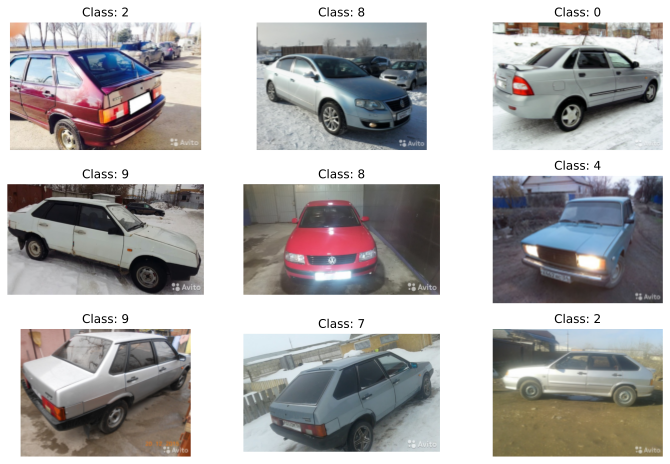

In [14]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

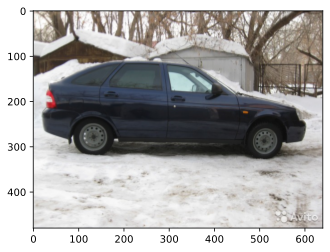

(640, 480)

In [15]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

### Уже догадываетесь, что означают классы?

# Подготовка данных

### Аугментация данных

In [20]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

In [21]:
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=10, 
                       p=.75),
#     A.OneOf([
#         A.CenterCrop(height=224, width=200),
#         A.CenterCrop(height=200, width=224)],
#         p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

In [22]:
# Вы помните, что аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.
# Чтобы лучше понять работу параметров, попробуйте их изменить. К какому результату это приведет?
# Официальная документация: https://keras.io/preprocessing/image/

# train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     rotation_range = 5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    
#     validation_split=VAL_SPLIT, # set validation split
#     horizontal_flip=False)

train_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

test_datagen = ImageDataGenerator(rescale=1. / 255)

#Рекомендация Подключите более продвинутые библиотеки аугментации изображений (например: albumentations или imgaug, для них есть специальные "обертки" под Keras, например: https://github.com/mjkvaak/ImageDataAugmentor)

### Генерация данных

In [32]:
# Завернем наши данные в генератор:

train_generator = train_gen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training') # set as training data

test_generator = train_gen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# Обратите внимание, что для сабмита мы используем другой источник test_datagen.flow_from_dataframe. Как вы думаете, почему?

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


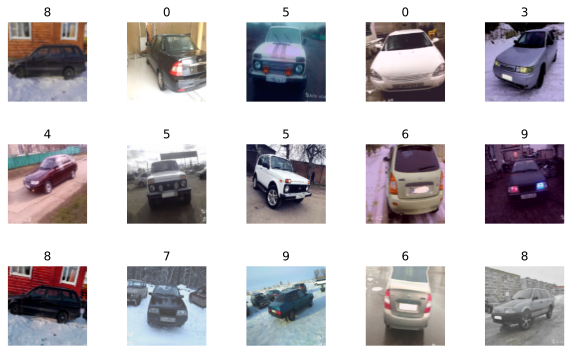

In [24]:
train_generator.show_data(rows=3, cols=5)

# Построение модели

### Загружаем предобученную сеть Xception:

In [33]:
#base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)
base_model = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape = input_shape)

In [34]:
base_model.summary()

Model: "efficientnet-b5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 48) 1296        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [58]:
# Замораживаем базовую модель для файн тюнинга
base_model.trainable = False

# Устанавливаем новую "голову" (head)
model=Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [36]:
model.summary()
# Рекомендация: Попробуйте добавить Batch Normalization

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 28,868,410
Non-trainable params: 173,248
____________________________________

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [37]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
# Наши колбэки модели
callbacks_list = [checkpoint, earlystop, reduce_lr]


Обучаем:

In [38]:
# Обучаем базовую модель
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5
414/414 [==============================] - 331s 746ms/step - loss: 1.6102 - accuracy: 0.4966 - val_loss: 0.4707 - val_accuracy: 0.8510

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
414/414 [==============================] - 304s 734ms/step - loss: 0.4728 - accuracy: 0.8422 - val_loss: 0.2706 - val_accuracy: 0.9017

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
414/414 [==============================] - 303s 731ms/step - loss: 0.2853 - accuracy: 0.9035 - val_loss: 0.3219 - val_accuracy: 0.8987

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
414/414 [==============================] - 304s 733ms/step - loss: 0.2461 - accuracy: 0.9160 - val_loss: 0.1790 - val_accuracy: 0.9373

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
414/414 [==============================] - 304s 734ms/step - loss: 0.2006 - accuracy: 0.9324 - val_loss: 0.1975 - val_accuracy: 0.9296

Epoch 00005: saving model to best_model.hdf5


In [39]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [40]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

73/73 [==============================] - 25s 344ms/step - loss: 0.2180 - accuracy: 0.9279
Accuracy: 92.79%


В Итоге точность нашей модели составила 93%. 
Учитывая что классов 10 - это Очень хороший результат!     
Посмотрим графики обучения:

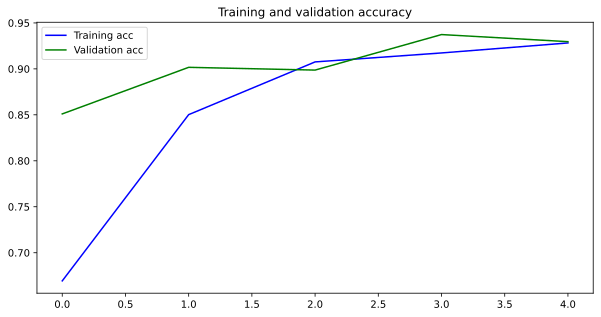

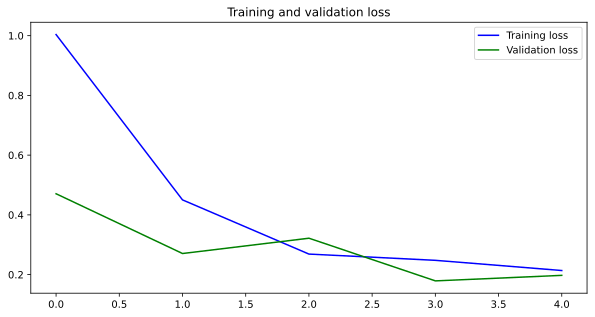

In [43]:
plot_history(history)

## STEP 2

In [ ]:
# Проверим количество слоев в нашей базовой модели
print("Количество слоев в base model: ", len(base_model.layers))

### Попробуем файн-тюнинг на половине слоев

In [ ]:
base_model.trainable = True

# Fine-tune
fine_tune_at = len(base_model.layers)//2

# Заморозим все слои до fine_tune
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
print(f'Количество обучаемых параметров: {len(base_model.trainable_variables)}')

In [ ]:
# Проверим статус слоев на trainable
for layer in model.layers:
    print(layer, layer.trainable)

In [ ]:
# Уменьшим LR и скомпилим новую модель
LR=1e-4
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
# Проверим текущий скор на тесте
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 10,
        callbacks = callbacks_list
)

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
plot_history(history)

## STEP 3

In [ ]:
# Добиваем обучение модели
base_model.trainable = True

In [ ]:
# Еще сильнее понижаем LR
LR=1e-5
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 10,
        callbacks = callbacks_list
)

In [ ]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

## STEP 4

In [ ]:
EPOCHS               = 10
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [ ]:
model.save('../working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

# Предсказание IMG_SIZE RISE

In [44]:
test_sub_generator.samples

6675

In [45]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


209/209 [==============================] - 46s 197ms/step


In [46]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

# Рекомендация: попробуйте добавить Test Time Augmentation (TTA)
# https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Save submit


In [47]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,3
3,93598.jpg,7
4,87877.jpg,7


# Test Time Augmentation

In [48]:
model.load_weights('best_model.hdf5')

In [49]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

In [50]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [51]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

209/209 [==============================] - 100s 480ms/step


In [54]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

submission['Id'] = submission['Id'].replace('test_upload/','')

In [57]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

ValueError: Failed to find data adapter that can handle input: <class 'tensorflow.python.keras.preprocessing.image.ImageDataGenerator'>, <class 'NoneType'>

In [56]:
submission.to_csv('submission_TTA.csv', index=False)

In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH)

## Интересно, к какому классу модель отнесет вот эти автомобили?

# Что можно сделать, чтобы улучшить результат:

* Примените transfer learning с fine-tuning
* Настройте LR, optimizer, loss
* Подберите другие переменные (размер картинки, батч и т.д.)
* Попробуйте и другие архитектуры сетей (а не только Xception) или их ансамбли. Примеры SOTA на ImageNet  
* 
* Добавьте Batch Normalization и поэкспериментируйте с архитектурой “головы”
* Примените другие функции callback Keras https://keras.io/callbacks/ 
* Добавьте TTA (Test Time Augmentation)
* Дополнительно*: Используйте разные техники управления Learning Rate (https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng) http://teleported.in/posts/cyclic-learning-rate/ (eng))
* Дополнительно*: Добавьте более продвинутые библиотеки аугментации изображений (например, Albumentations )

### Удачи в соревновании!